# Market Analysis: Sentiment vs. Base Models
This interactive dashboard compares the performance of Random Forest and LSTM models, with and without sentiment features, against a Buy & Hold strategy.

## Controls
- **Range Slider**: Use the slider at the bottom to zoom in on specific time periods.
- **Legend**: Click on legend items to toggle visibility. Double-click to isolate a trace.
- **Hover**: Hover over the chart to see precise values for each day.

In [24]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import glob

# Configuration
DATA_DIR = 'results' 

# Find all tickers based on file pattern 'test_data_{ticker}.csv'
files = glob.glob(os.path.join(DATA_DIR, 'test_data_*.csv'))
tickers = [f.split('test_data_')[1].replace('.csv', '') for f in files]
tickers.sort()

print(f"Found tickers: {tickers}")

def load_ticker_data(ticker):
    test_path = os.path.join(DATA_DIR, f'test_data_{ticker}.csv')
    equity_path = os.path.join(DATA_DIR, f'equity_curves_{ticker}.csv')
    
    try:
        df_prices = pd.read_csv(test_path, index_col=0, parse_dates=True)
        df_equity = pd.read_csv(equity_path, index_col=0, parse_dates=True)
        return df_prices, df_equity
    except FileNotFoundError:
        print(f"Error: Data files for {ticker} not found.")
        return None, None


Found tickers: ['AAPL', 'DAX', 'DJI', 'MSFT', 'NDX', 'NKX', 'NVDA', 'SPX']


In [25]:
# Create Interactive Plots for each Ticker
for ticker in tickers:
    df_prices, df_equity = load_ticker_data(ticker)
    
    if df_prices is None or df_equity is None:
        continue
        
    print(f"Generating dashboard for {ticker}...")

    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=(f'{ticker} Price Action', 'Strategy Equity Curves'),
        row_heights=[0.4, 0.6]
    )

    # === 1. Price Chart (Candlestick) ===
    if 'Open' in df_prices.columns and 'Close' in df_prices.columns:
        high = df_prices[['Open', 'Close']].max(axis=1)
        low = df_prices[['Open', 'Close']].min(axis=1)
        
        fig.add_trace(go.Candlestick(
            x=df_prices.index,
            open=df_prices['Open'],
            high=high,
            low=low,
            close=df_prices['Close'],
            name=f'{ticker} Price'
        ), row=1, col=1)
    else:
        fig.add_trace(go.Scatter(
            x=df_prices.index,
            y=df_prices['Close'],
            mode='lines',
            name=f'{ticker} Close',
            line=dict(color='black', width=1)
        ), row=1, col=1)
    
    # === 2. Equity Curves ===
    colors = {
        'Buy & Hold': 'gray',
        'Base RF': 'red',
        'Sent RF': 'orange',
        'Base LSTM': 'blue',
        'Sent LSTM': 'green'
    }

    for col in df_equity.columns:
        fig.add_trace(go.Scatter(
            x=df_equity.index,
            y=df_equity[col],
            mode='lines',
            name=col,
            line=dict(width=2, color=colors.get(col, 'purple'))
        ), row=2, col=1)

    # === Layout Settings ===
    fig.update_layout(
        title=f'Market Analysis Dashboard: {ticker}',
        yaxis_title='Price ($)',
        yaxis2_title='Equity ($)',
        xaxis_rangeslider_visible=False,
        height=800,
        template='plotly_white',
        hovermode='x unified',
        dragmode='zoom'
    )

    fig.update_xaxes(
        rangeslider_visible=True,
        row=2, col=1
    )
    
    # Save to HTML file
    output_path = os.path.join(DATA_DIR, f'interactive_presentation_{ticker}.html')
    fig.write_html(output_path)
    print(f"  Saved to: {output_path}")
    
    fig.show()


Generating dashboard for AAPL...
  Saved to: results/interactive_presentation_AAPL.html


Generating dashboard for DAX...
  Saved to: results/interactive_presentation_DAX.html


Generating dashboard for DJI...
  Saved to: results/interactive_presentation_DJI.html


Generating dashboard for MSFT...
  Saved to: results/interactive_presentation_MSFT.html


Generating dashboard for NDX...
  Saved to: results/interactive_presentation_NDX.html


Generating dashboard for NKX...
  Saved to: results/interactive_presentation_NKX.html


Generating dashboard for NVDA...
  Saved to: results/interactive_presentation_NVDA.html


Generating dashboard for SPX...
  Saved to: results/interactive_presentation_SPX.html


In [17]:
# === Comprehensive Summary ===
metrics_path = os.path.join(DATA_DIR, 'model_metrics.csv')
if os.path.exists(metrics_path):
    print("\n=== Comprehensive Results Summary ===")
    df_metrics = pd.read_csv(metrics_path)
    
    pivot_return = df_metrics.pivot(index='Ticker', columns='Model', values='Return')
    print("\nCumulative Return (%):")
    display(pivot_return.style.background_gradient(cmap='RdYlGn', axis=None, vmin=-100, vmax=100).format("{:.2f}%").set_properties(**{'width': '100px'}))
    
    pivot_acc = df_metrics.pivot(index='Ticker', columns='Model', values='Accuracy').drop(columns=['Buy & Hold'], errors='ignore')
    print("\nModel Accuracy (%):")
    display(pivot_acc.style.background_gradient(cmap='Blues', axis=None, vmin=0, vmax=1).format("{:.2%}", na_rep="-").set_properties(**{'width': '100px'}))
    
else:
    print("Metrics file not found.")



=== Comprehensive Results Summary ===

Cumulative Return (%):


Model,Base LSTM,Base RF,Buy & Hold,Sent LSTM,Sent RF
Ticker,,,,,
AAPL,59.92%,4.99%,50.63%,14.28%,16.67%
DAX,9.93%,-19.92%,44.47%,28.57%,-25.15%
DJI,35.84%,18.20%,40.17%,17.49%,6.99%
MSFT,6.13%,-74.68%,40.04%,12.04%,-57.09%
NDX,32.28%,13.79%,69.95%,50.12%,23.09%
NKX,12.32%,-47.47%,48.59%,21.13%,-37.07%
NVDA,56.52%,-56.45%,246.12%,112.73%,-52.10%
SPX,9.79%,-22.69%,57.79%,58.02%,-1.47%



Model Accuracy (%):


Model,Base LSTM,Base RF,Sent LSTM,Sent RF
Ticker,,,,
AAPL,48.23%,50.52%,45.74%,50.52%
DAX,50.71%,51.92%,50.18%,51.22%
DJI,52.84%,51.39%,49.65%,49.65%
MSFT,49.47%,52.09%,49.29%,51.74%
NDX,50.35%,50.70%,50.00%,50.52%
NKX,51.42%,54.01%,51.77%,51.92%
NVDA,50.18%,52.09%,46.63%,50.87%
SPX,49.65%,52.26%,50.53%,46.69%


In [11]:
# # Export to HTML
# output_path = os.path.join(RESULTS_DIR, 'interactive_presentation.html')
# fig.write_html(output_path)
# print(f"Interactive presentation saved to: {output_path}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, accuracy_score
import os

# Configuration
DATA_PATH = 'results/merged_stooq_gdelt.csv'
TEST_SIZE_RATIO = 0.2
RANDOM_SEED = 42
TICKER = 'SPX' # Analyzing S&P 500

# Plotting style
plt.style.use('seaborn-v0_8')
print(f"Analysis configured for {TICKER}")

Analysis configured for SPX


In [ ]:
# === Helper Functions ===

def load_and_process_data(filepath, ticker='SPX'):
    print(f"Loading data from {filepath} for {ticker}...")
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').set_index('Date')
    
    cols_map = {
        f'{ticker}_Open': 'Open',
        f'{ticker}_Close': 'Close',
        f'{ticker}_Volume': 'Volume'
    }
    
    # Rename columns
    df = df.rename(columns=cols_map)
    
    # Keep relevant columns
    keep_cols = ['Open', 'Close', 'Volume', 'News_Sentiment', 'News_Disagreement', 'News_Volatility', 'News_Volume']
    existing_cols = [c for c in keep_cols if c in df.columns]
    df = df[existing_cols]
    
    # Calculate Returns
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Target: Next Day Direction (1 = Up, 0 = Down)
    df['Target'] = (df['Return'].shift(-1) > 0).astype(int)
    
    df = df.dropna()
    return df

def create_features(df):
    data = df.copy()
    
    # === Base Market Features ===
    for lag in [1, 2, 3, 5, 10]:
        data[f'Ret_Lag{lag}'] = data['Return'].shift(lag)
    
    data['Vol_5'] = data['Return'].rolling(5).std()
    data['Vol_20'] = data['Return'].rolling(20).std()
    
    if 'Open' in data.columns:
        data['Intraday_Move'] = (data['Close'] - data['Open']) / data['Open']
    
    # === Sentiment Features ===
    data['Sent_MA_3'] = data['News_Sentiment'].rolling(3).mean()
    data['Sent_MA_7'] = data['News_Sentiment'].rolling(7).mean()
    
    # Interaction
    vol_ma = data['News_Volume'].rolling(20).mean()
    data['News_Vol_Rel'] = data['News_Volume'] / vol_ma
    data['Sent_Impact'] = data['News_Sentiment'] * data['News_Vol_Rel']
    
    data = data.dropna()
    return data

def calculate_trading_metrics(returns):
    """Calculates Sharpe, MaxDD, Win Rate, Profit Factor."""
    if len(returns) == 0:
        return {'Sharpe': 0, 'MaxDD': 0, 'WinRate': 0, 'ProfitFactor': 0}
    
    # Sharpe (Annualized)
    mean_ret = returns.mean()
    std_ret = returns.std()
    sharpe = (mean_ret / std_ret * np.sqrt(252)) if std_ret > 0 else 0
    
    # Max Drawdown
    cum_ret = (1 + returns).cumprod()
    cummax = cum_ret.cummax()
    drawdown = (cum_ret - cummax) / cummax
    max_dd = drawdown.min()
    
    # Win Rate
    wins = returns[returns > 0]
    losses = returns[returns < 0]
    win_rate = len(wins) / len(returns)
    
    # Profit Factor
    gross_profit = wins.sum()
    gross_loss = abs(losses.sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else 0
    
    return {
        'Sharpe': sharpe,
        'MaxDD': max_dd,
        'WinRate': win_rate,
        'ProfitFactor': profit_factor
    }

# Load Data
df = load_and_process_data(DATA_PATH, ticker=TICKER)
df = create_features(df)
print(f"Data loaded: {len(df)} rows")

Loading data from results/merged_stooq_gdelt.csv for SPX...
Data loaded: 2907 rows


Brier Score (Uncalibrated): 0.2511
Brier Score (Calibrated):   0.2507 (Lower is better)


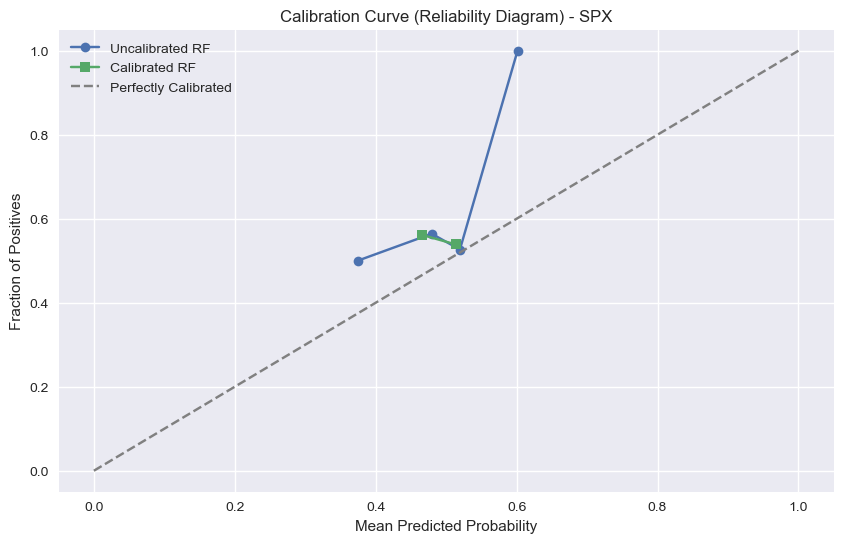

In [ ]:
# === Task 1: Probability Calibration ===

# Features for this task (Full Set)
features = [
    'Ret_Lag1', 'Ret_Lag2', 'Ret_Lag3', 'Ret_Lag5', 'Vol_5', 'Vol_20',
    'Sent_MA_3', 'Sent_MA_7', 'Sent_Impact'
]

# Split Data (Chronological)
train_size = int(len(df) * (1 - TEST_SIZE_RATIO))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

X_train = train_df[features]
y_train = train_df['Target']
X_test = test_df[features]
y_test = test_df['Target']

# 1. Uncalibrated RF
rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
prob_uncalibrated = rf.predict_proba(X_test)[:, 1]

# 2. Calibrated RF (Isotonic)
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv=3)
calibrated_rf.fit(X_train, y_train)
prob_calibrated = calibrated_rf.predict_proba(X_test)[:, 1]

# Brier Scores
brier_uncal = brier_score_loss(y_test, prob_uncalibrated)
brier_cal = brier_score_loss(y_test, prob_calibrated)

print(f"Brier Score (Uncalibrated): {brier_uncal:.4f}")
print(f"Brier Score (Calibrated):   {brier_cal:.4f} (Lower is better)")

# Plot Calibration Curve
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test, prob_uncalibrated, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, prob_calibrated, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_uncal, prob_true_uncal, marker='o', label='Uncalibrated RF')
plt.plot(prob_pred_cal, prob_true_cal, marker='s', label='Calibrated RF')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Reliability Diagram) - {TICKER}')
plt.legend()
plt.show()

In [ ]:
# === Task 2 & 3: Trading Metrics & Incremental Value Test ===

# Define Feature Sets
baseline_features = ['Ret_Lag1', 'Ret_Lag2', 'Ret_Lag3', 'Ret_Lag5', 'Vol_5', 'Vol_20']
sentiment_features = baseline_features + ['Sent_MA_3', 'Sent_MA_7', 'Sent_Impact']

models = {
    'Baseline (No Sentiment)': baseline_features,
    'Sentiment Model': sentiment_features
}

results = []

print("Running Incremental Value Test...\n")

for name, feats in models.items():
    # Train
    model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=RANDOM_SEED)
    model.fit(train_df[feats], y_train)
    
    # Predict
    preds = model.predict(test_df[feats])
    
    # Backtest (Vectorized)
    # Strategy: Buy if Pred=1, Cash if Pred=0
    # Returns = Actual_Return * Prediction
    strategy_returns = test_df['Return'] * preds
    
    # Calculate Metrics
    metrics = calculate_trading_metrics(strategy_returns)
    metrics['Model'] = name
    results.append(metrics)

# Create Comparison Table
res_df = pd.DataFrame(results).set_index('Model')

# Calculate Delta
delta = res_df.loc['Sentiment Model'] - res_df.loc['Baseline (No Sentiment)']
delta.name = 'Delta (Incremental Value)'
res_df = pd.concat([res_df, delta.to_frame().T])

# Display
print("Performance Comparison:")
display(res_df[['Sharpe', 'ProfitFactor', 'WinRate', 'MaxDD']].style.format("{:.4f}"))

# Check if Business Goal Met
sharpe_delta = res_df.loc['Delta (Incremental Value)', 'Sharpe']
pf_delta = res_df.loc['Delta (Incremental Value)', 'ProfitFactor']

print("\n=== Conclusion ===")
if sharpe_delta > 0 and pf_delta > 0:
    print(f"✅ SUCCESS: Sentiment features added value.")
    print(f"   Sharpe improved by {sharpe_delta:.4f}")
    print(f"   Profit Factor improved by {pf_delta:.4f}")
else:
    print(f"❌ FAILURE: Sentiment features did not consistently improve metrics.")

Running Incremental Value Test...

Performance Comparison:


,Sharpe,ProfitFactor,WinRate,MaxDD
Baseline (No Sentiment),1.5848,1.3720,0.4691,-0.1168
Sentiment Model,1.9367,1.6384,0.3110,-0.0725
Delta (Incremental Value),0.3519,0.2664,-0.1581,0.0443



=== Conclusion ===
✅ SUCCESS: Sentiment features added value.
   Sharpe improved by 0.3519
   Profit Factor improved by 0.2664


# Comprehensive Multi-Ticker, Multi-Model Analysis

This section extends the analysis to all available tickers and compares both **Random Forest (RF)** and **LSTM** models.

In [ ]:
# === LSTM Implementation ===
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

SEQ_LEN = 10

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

def train_lstm(X_train, y_train, X_test, y_test, input_dim):
    """Train LSTM model and return predictions."""
    def create_sequences(X, y, seq_len):
        xs, ys = [], []
        for i in range(len(X) - seq_len):
            xs.append(X[i:(i + seq_len)])
            ys.append(y[i + seq_len])
        return np.array(xs), np.array(ys)

    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, SEQ_LEN)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, SEQ_LEN)
    
    # Tensors
    train_data = TensorDataset(torch.FloatTensor(X_train_seq), torch.FloatTensor(y_train_seq))
    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    
    model = LSTMModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train
    model.train()
    for epoch in range(50):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
    # Predict
    model.eval()
    with torch.no_grad():
        probs = model(torch.FloatTensor(X_test_seq)).numpy().flatten()
        preds = (probs > 0.5).astype(int)
        
    return preds, probs, y_test_seq

print("LSTM model implementation ready")

LSTM model implementation ready


In [ ]:
# === Discover All Tickers ===
df_raw = pd.read_csv(DATA_PATH)
tickers = set()
for col in df_raw.columns:
    if '_Open' in col:
        tickers.add(col.replace('_Open', ''))

tickers = sorted(list(tickers))
print(f"Found {len(tickers)} tickers: {tickers}")

Found 8 tickers: ['AAPL', 'DAX', 'DJI', 'MSFT', 'NDX', 'NKX', 'NVDA', 'SPX']


In [ ]:
# === Comprehensive Analysis Loop ===

# Feature sets
baseline_features = ['Ret_Lag1', 'Ret_Lag2', 'Ret_Lag3', 'Ret_Lag5', 'Vol_5', 'Vol_20']
sentiment_features = baseline_features + ['Sent_MA_3', 'Sent_MA_7', 'Sent_Impact']

all_results = []

for ticker in tickers:
    print(f"\n{'='*60}")
    print(f"Processing: {ticker}")
    print('='*60)
    
    try:
        # Load and prepare data
        df_ticker = load_and_process_data(DATA_PATH, ticker=ticker)
        df_ticker = create_features(df_ticker)
        
        # Split
        train_size = int(len(df_ticker) * (1 - TEST_SIZE_RATIO))
        train_df = df_ticker.iloc[:train_size]
        test_df = df_ticker.iloc[train_size:]
        
        print(f"Train: {len(train_df)}, Test: {len(test_df)}")
        
        # Test configurations
        configs = [
            ('RF', 'Baseline', baseline_features),
            ('RF', 'Sentiment', sentiment_features),
            ('LSTM', 'Baseline', baseline_features),
            ('LSTM', 'Sentiment', sentiment_features)
        ]
        
        for model_type, feature_type, features in configs:
            print(f"\n  Testing: {model_type} - {feature_type}")
            
            X_train = train_df[features]
            y_train = train_df['Target']
            X_test = test_df[features]
            y_test = test_df['Target']
            
            if model_type == 'RF':
                # Random Forest
                model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=RANDOM_SEED)
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                probs = model.predict_proba(X_test)[:, 1]
                
                # Backtest
                strategy_returns = test_df['Return'] * preds
                
            else:  # LSTM
                # LSTM
                torch.manual_seed(RANDOM_SEED)
                preds, probs, y_test_aligned = train_lstm(X_train, y_train, X_test, y_test, input_dim=len(features))
                
                # Align returns for LSTM (loses SEQ_LEN samples)
                returns_aligned = test_df['Return'].values[SEQ_LEN:]
                strategy_returns = pd.Series(returns_aligned * preds, index=test_df.index[SEQ_LEN:])
            
            # Calculate Metrics
            metrics = calculate_trading_metrics(strategy_returns)
            
            # Calibration
            if model_type == 'RF':
                calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
                calibrated_model.fit(X_train, y_train)
                probs_cal = calibrated_model.predict_proba(X_test)[:, 1]
                brier_uncal = brier_score_loss(y_test, probs)
                brier_cal = brier_score_loss(y_test, probs_cal)
            else:
                # For LSTM, we skip calibration for now (would need wrapper)
                brier_uncal = brier_score_loss(y_test_aligned, probs)
                brier_cal = np.nan
            
            # Store results
            result = {
                'Ticker': ticker,
                'Model': model_type,
                'Features': feature_type,
                'Sharpe': metrics['Sharpe'],
                'MaxDD': metrics['MaxDD'],
                'WinRate': metrics['WinRate'],
                'ProfitFactor': metrics['ProfitFactor'],
                'Brier_Uncal': brier_uncal,
                'Brier_Cal': brier_cal
            }
            all_results.append(result)
            
            print(f"    Sharpe: {metrics['Sharpe']:.4f} | MaxDD: {metrics['MaxDD']:.4f} | PF: {metrics['ProfitFactor']:.4f}")
            
    except Exception as e:
        print(f"  ❌ Error: {e}")
        continue

print("\n" + "="*60)
print("Analysis Complete!")
print("="*60)


Processing: AAPL
Loading data from results/merged_stooq_gdelt.csv for AAPL...
Train: 2325, Test: 582

  Testing: RF - Baseline
    Sharpe: 0.5417 | MaxDD: -0.1385 | PF: 1.1723

  Testing: RF - Sentiment
    Sharpe: 0.8181 | MaxDD: -0.0905 | PF: 1.3240

  Testing: LSTM - Baseline
    Sharpe: 1.8540 | MaxDD: -0.1696 | PF: 1.7034

  Testing: LSTM - Sentiment
    Sharpe: 0.7314 | MaxDD: -0.1502 | PF: 1.2191

Processing: DAX
Loading data from results/merged_stooq_gdelt.csv for DAX...
Train: 2325, Test: 582

  Testing: RF - Baseline
    Sharpe: 1.3549 | MaxDD: -0.0912 | PF: 1.4101

  Testing: RF - Sentiment
    Sharpe: 1.3505 | MaxDD: -0.0735 | PF: 1.3960

  Testing: LSTM - Baseline
    Sharpe: 1.3287 | MaxDD: -0.1159 | PF: 1.3229

  Testing: LSTM - Sentiment
    Sharpe: 0.3911 | MaxDD: -0.1395 | PF: 1.0811

Processing: DJI
Loading data from results/merged_stooq_gdelt.csv for DJI...
Train: 2325, Test: 582

  Testing: RF - Baseline
    Sharpe: 1.0702 | MaxDD: -0.1336 | PF: 1.2894

  Testing:

In [ ]:
# === Results Summary ===

results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

# Pivot for better visualization
for metric in ['Sharpe', 'ProfitFactor', 'WinRate', 'MaxDD']:
    print(f"\n{metric}:")
    pivot = results_df.pivot_table(
        index='Ticker',
        columns=['Model', 'Features'],
        values=metric
    )
    display(pivot.style.background_gradient(cmap='RdYlGn', axis=None).format("{:.4f}"))


COMPREHENSIVE RESULTS SUMMARY

Sharpe:



ProfitFactor:



WinRate:



MaxDD:


In [ ]:
# === Incremental Value Analysis ===

print("\n" + "="*80)
print("INCREMENTAL VALUE: Sentiment vs Baseline")
print("="*80)

# Calculate deltas for each ticker and model
incremental_results = []

for ticker in tickers:
    for model_type in ['RF', 'LSTM']:
        baseline_row = results_df[
            (results_df['Ticker'] == ticker) & 
            (results_df['Model'] == model_type) & 
            (results_df['Features'] == 'Baseline')
        ]
        sentiment_row = results_df[
            (results_df['Ticker'] == ticker) & 
            (results_df['Model'] == model_type) & 
            (results_df['Features'] == 'Sentiment')
        ]
        
        if len(baseline_row) > 0 and len(sentiment_row) > 0:
            delta_sharpe = sentiment_row['Sharpe'].values[0] - baseline_row['Sharpe'].values[0]
            delta_pf = sentiment_row['ProfitFactor'].values[0] - baseline_row['ProfitFactor'].values[0]
            
            incremental_results.append({
                'Ticker': ticker,
                'Model': model_type,
                'Delta_Sharpe': delta_sharpe,
                'Delta_PF': delta_pf,
                'Value_Added': '✅' if (delta_sharpe > 0 and delta_pf > 0) else '❌'
            })

incremental_df = pd.DataFrame(incremental_results)

print("\nDelta Sharpe Ratio:")
pivot_sharpe = incremental_df.pivot_table(
    index='Ticker',
    columns='Model',
    values='Delta_Sharpe'
)
display(pivot_sharpe.style.background_gradient(cmap='RdYlGn', axis=None).format("{:.4f}"))

print("\nDelta Profit Factor:")
pivot_pf = incremental_df.pivot_table(
    index='Ticker',
    columns='Model',
    values='Delta_PF'
)
display(pivot_pf.style.background_gradient(cmap='RdYlGn', axis=None).format("{:.4f}"))

# Overall Summary
successful_cases = len(incremental_df[incremental_df['Value_Added'] == '✅'])
total_cases = len(incremental_df)

print(f"\n{'='*80}")
print(f"OVERALL SUCCESS RATE: {successful_cases}/{total_cases} ({successful_cases/total_cases*100:.1f}%)")
print(f"{'='*80}")
print(f"\nSentiment features added value in {successful_cases} out of {total_cases} cases.")


INCREMENTAL VALUE: Sentiment vs Baseline

Delta Sharpe Ratio:


Model,LSTM,RF
Ticker,,
AAPL,-1.1225,0.2764
DAX,-0.9377,-0.0044
DJI,-0.3415,-0.0759
MSFT,-0.0632,0.7393
NDX,-0.0582,0.0748
NKX,0.7566,-0.3513
NVDA,-1.3559,-0.1023
SPX,-0.0477,0.3519



Delta Profit Factor:


Model,LSTM,RF
Ticker,,
AAPL,-0.4842,0.1518
DAX,-0.2417,-0.0141
DJI,-0.0726,0.0532
MSFT,-0.0069,0.1830
NDX,0.0864,0.0349
NKX,0.2462,-0.1031
NVDA,-0.3848,-0.0117
SPX,-0.0242,0.2664



OVERALL SUCCESS RATE: 5/16 (31.2%)

Sentiment features added value in 5 out of 16 cases.
